In [2]:
!pip install langgraph groq langchain_groq

Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: xxhash
    Found existing installation: xxhash 3.4.1
    Uninstalling xxhash-3.4.1:
      Successfully uninstalled xxhash-3.4.1
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.24
    Uninstalling langsmith-0.3.24:
      Successfully uninstalled langsmith-0.3.24
  Attempting uninstall: groq
    Found existing installation: groq 0.9.0
    Uninstalling groq-0.9.0:
      Successfully uninstalled groq-0.9.0
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.51
    Uninstalling langchain-core-0.3.51:
      Successfully uninstalled langchain-core-0.3.51


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
agentic-patterns 1.0.0 requires groq<0.10.0,>=0.9.0, but you have groq 0.30.0 which is incompatible.
langchain 0.3.23 requires langsmith<0.4,>=0.1.17, but you have langsmith 0.4.5 which is incompatible.
langchain-community 0.3.21 requires langsmith<0.4,>=0.1.125, but you have langsmith 0.4.5 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# The optimized graph system :

In [5]:
import os
import logging
import requests
import json
import re
from datetime import datetime, timedelta
from typing import Annotated, Sequence, TypedDict, List, Dict, Optional

from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from groq import Groq

**Logging**

In [6]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

**API keys** 

In [ ]:
os.environ["GROQ_API_KEY"] = "GROQ_API_KEY"
ALPHA_VANTAGE_API_KEY = "ALPHA_VANTAGE_API_KEY"
TAVILY_API_KEY = "TAVILY_API_KEY"
SHODAN_API_KEY = "SHODAN_API_KEY"

**LLM :**

In [8]:
try:
    client = Groq(api_key=os.environ["GROQ_API_KEY"])
    llm = ChatGroq(model="gemma2-9b-it", api_key=os.environ["GROQ_API_KEY"], temperature=0.1)
except Exception as e:
    logger.error(f"Failed to initialize LLM: {e}")
    raise

**Agent State**

In [7]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    company_name: str
    ticker_symbol: Optional[str]
    current_findings: Dict[str, str]
    completed_tasks: List[str]
    final_report: str

**Travily search function:**

In [8]:
def tavily_search(query: str, max_results: int = 5) -> Dict:
    """Helper function to perform a Tavily search."""
    try:
        payload = {
            "api_key": TAVILY_API_KEY,
            "query": query,
            "search_depth": "advanced",
            "include_answer": True,
            "include_raw_content": True,
            "max_results": max_results
        }
        response = requests.post("https://api.tavily.com/search", json=payload)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        logger.error(f"Tavily search error for query '{query}': {e}")
        return {"results": [], "answer": "Search failed"}


**Tools :**

In [39]:
@tool
def deep_search_and_summarize_tool(company_name: str) -> str:
    """
    Performs an advanced deep search to gather comprehensive company information, 
    including obvious and hidden insights. Synthesizes results into a detailed Company Profile.
    """
    print(f"🧠 Deep Search Tool - Researching: {company_name}")
    
    # Expanded multi-dimensional queries
    queries = {
        "overview": f"{company_name} company overview, structure, and business model",
        "history": f"{company_name} company history, origin, and milestones",
        "products": f"{company_name} key products, services, markets, and innovations",
        "tax": f"{company_name} tax practices, effective tax rate, tax avoidance controversies",
        "compliance": f"{company_name} regulatory fines, ESG compliance, GDPR, or SEC issues",
        "legal": f"{company_name} controversies, lawsuits, legal settlements, ethical issues",
        "swot": f"SWOT analysis of {company_name}",
        "hq": f"{company_name} headquarters location, incorporation country, and legal name",
        "ownership": f"{company_name} ownership structure, investors, founders, shareholders",
        "multinational": f"is {company_name} a multinational? list countries of operation"
    }

    all_results = {}
    for key, query in queries.items():
        print(f"  -> Searching for: {query}")
        try:
            search_data = tavily_search(query, max_results=3)
            results = search_data.get("results", [])
            all_results[key] = "\n".join([
                f"- {res.get('title', '')}: {res.get('content', '')[:1000]}..." for res in results
            ])
        except Exception as e:
            all_results[key] = f"Search error for {key}: {str(e)}"

    # System prompt with deep analysis instructions
    synthesis_prompt = f"""
You are a senior corporate intelligence analyst. Using the structured web search results below, compile a comprehensive **Company Profile** for {company_name}. Your job is to extract both **obvious** and **hidden or less-publicized** insights about the company’s identity, operations, reputation, and structure.

Structure your analysis with the following sections:

---

**1. Corporate Overview**  
- Full legal name and official headquarters (city, country).  
- Year founded and by whom.  
- Nature of business, industry, and operating model.  
- Public or private? Listed stock ticker (if any).  
- Is it a multinational? Approximate number of countries of operation.

---

**2. Products and Services**  
- Key products, services, technologies, and innovations.  
- Major markets served (geographies and sectors).  
- Business lines (if diversified).

---

**3. Financial and Ownership Structure**  
- Ownership (public shareholders, founders, institutional investors, government involvement).  
- Approximate size: revenue, market cap, number of employees.  
- Major M&A activity or investment rounds (if relevant).

---

**4. Taxation and Compliance**  
- Tax residence(s) and any known tax haven involvement.  
- Effective tax rate and known tax strategies.  
- Involvement in tax evasion controversies or regulatory fines.  
- Any known compliance issues (e.g., GDPR, SEC, ESG violations).

---

**5. Controversies and Legal Risks**  
- Any notable lawsuits, fines, settlements, scandals, or public criticism.  
- Labor, ethical, environmental, or political controversies.  
- Blacklisting, bans, or regulatory hurdles in any countries.

---

**6. SWOT Analysis**  
Provide a final structured SWOT assessment:
- **Strengths**  
- **Weaknesses**  
- **Opportunities**  
- **Threats**

---

**Instructions:**  
- Be concise but informative.  
- Do NOT speculate — only use the evidence present in the results.  
- Do NOT reference or mention the source URLs.  
- Use clear paragraph formatting and bullet points when needed.  
- Focus on facts that are relevant to investors, regulators, or due diligence analysts.

---

**Search Results:**

**Corporate Overview:**  
{all_results['overview']}

**Headquarters and Legal Info:**  
{all_results['hq']}

**Multinational Presence:**  
{all_results['multinational']}

**History:**  
{all_results['history']}

**Products and Services:**  
{all_results['products']}

**Ownership Structure:**  
{all_results['ownership']}

**Taxation and Compliance:**  
{all_results['tax']}

**Regulatory and Compliance:**  
{all_results['compliance']}

**Legal Risks:**  
{all_results['legal']}

**SWOT Analysis:**  
{all_results['swot']}
"""

    try:
        response = llm.invoke([SystemMessage(content=synthesis_prompt)])
        synthesized_text = response.content
        print(f"✅ Deep Search Result: {synthesized_text[:200]}...")
        return synthesized_text
    except Exception as e:
        error_msg = f"Synthesis failed: {str(e)}"
        logger.error(error_msg)
        return error_msg


@tool
def find_ticker_symbol_tool(company_name: str) -> str:
    """
    Uses a targeted web search and LLM extraction to find the official stock ticker for a company.
    Avoids false matches with similarly named companies; returns NOT_FOUND if no exact match.
    """
    print(f"🔎 Ticker Finder Tool - Searching for ticker for: {company_name}")
    
    query = f"official stock ticker symbol for parent company of '{company_name}'"
    
    try:
        search_results = tavily_search(query, max_results=5)
        context = "\n".join([res.get("content", "") for res in search_results.get("results", [])])
        
        if not context:
            return "NOT_FOUND: No search results."
        
        system_prompt = f"""
You are a financial data extraction assistant. Your task is to extract the official stock ticker symbol for the company '{company_name}' or its parent company from the given text.

**Important Instructions:**
- ONLY return the ticker symbol if you are certain it belongs to '{company_name}' or its direct parent/holding company.
- If the text mentions multiple companies with similar or identical names, do NOT guess or infer tickers for companies other than the exact target.
- Do NOT return tickers for subsidiaries, unrelated companies, or similarly named entities.
- If you cannot confidently confirm the ticker belongs to '{company_name}', respond exactly with 'NOT_FOUND'.
- Return ONLY the ticker symbol (examples: AAPL, TSLA, MSFT, RDSA.PA, BHP.L) with market suffixes if applicable.
- Do NOT include explanations or extra text.

If no valid ticker is found, respond with 'NOT_FOUND'.
"""
        
        response = llm.invoke([
            SystemMessage(content=system_prompt),
            HumanMessage(content=f"Extract the stock ticker for '{company_name}' from this text:\n\n{context}")
        ]).content.strip().upper()
        
        # Basic sanity checks on response length and content
        if "NOT_FOUND" in response or len(response) > 10 or " " in response:
            print(f"⚠️ Ticker not found or invalid response from LLM: {response}")
            return "NOT_FOUND"
        
        print(f"✅ Ticker Found: {response}")
        return response
        
    except Exception as e:
        logger.error(f"Error in find_ticker_symbol_tool: {e}")
        return f"NOT_FOUND: An error occurred during search: {e}"

@tool
def financial_data_tool(ticker_symbol: str, company_name: str) -> str:
    """
    Retrieves and analyzes comprehensive financial data for a given ticker symbol,
    including key ratios, income statement details, and qualitative overview.
    """
    print(f"📊 Financial Data Tool - Analyzing financial data for: {ticker_symbol}")
    
    if not ticker_symbol or "NOT_FOUND" in ticker_symbol:
        return "Financial analysis skipped: No valid ticker symbol was found for the company."

    report = f"FINANCIAL ANALYSIS for {ticker_symbol}:\n"
    raw_data_for_appendix = "\n\n--- Raw Financial Data ---\n"

    try:
        # Price Data
        price_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker_symbol}&apikey={ALPHA_VANTAGE_API_KEY}"
        price_response = requests.get(price_url, timeout=30).json()
        
        report += "\n--- STOCK PERFORMANCE ---\n"
        if "Time Series (Daily)" in price_response and price_response["Time Series (Daily)"]:
            latest_date = list(price_response["Time Series (Daily)"].keys())[0]
            data = price_response["Time Series (Daily)"][latest_date]
            report += f"Latest Closing Price ({latest_date}): ${data['4. close']}\n"
            report += f"Volume: {data['5. volume']}\n"
            raw_data_for_appendix += f"Latest Closing Price ({latest_date}): ${data['4. close']}\nVolume: {data['5. volume']}\n"
        else:
            report += "Stock price data not available via API.\n"

        # Overview Data
        overview_url = f"https://www.alphavantage.co/query?function=OVERVIEW&symbol={ticker_symbol}&apikey={ALPHA_VANTAGE_API_KEY}"
        overview_response = requests.get(overview_url, timeout=30).json()
        
        report += "\n--- KEY FINANCIAL METRICS ---\n"
        if overview_response and "MarketCapitalization" in overview_response and overview_response["MarketCapitalization"] != "None":
            market_cap = int(overview_response.get('MarketCapitalization', 0))
            pe_ratio = overview_response.get('PERatio', 'N/A')
            dividend_yield = overview_response.get('DividendYield', 'N/A')
            report += f"Market Cap: ${market_cap:,}\n"
            report += f"P/E Ratio: {pe_ratio}\n"
            report += f"Dividend Yield: {dividend_yield}\n"
            raw_data_for_appendix += f"Market Cap: ${market_cap:,}\nP/E Ratio: {pe_ratio}\nDividend Yield: {dividend_yield}\n"
            report += f"\nDescription: {overview_response.get('Description', 'N/A')[:400]}...\n"
            report += f"Sector: {overview_response.get('Sector', 'N/A')}\nIndustry: {overview_response.get('Industry', 'N/A')}\n"

        else:
            print("  -> API failed for Overview. Falling back to web search...")
            report += "(from Web Search Fallback)\n"
            search_results = tavily_search(f"{company_name} market cap, P/E ratio, and dividend yield")
            answer = search_results.get("answer", "Could not find overview data via web search.")
            report += f"{answer}\n"

        # Income Statement Data
        income_url = f"https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticker_symbol}&apikey={ALPHA_VANTAGE_API_KEY}"
        income_response = requests.get(income_url, timeout=30).json()
        
        report += "\n--- LATEST QUARTERLY EARNINGS ---\n"
        if income_response and "quarterlyReports" in income_response and income_response["quarterlyReports"]:
            latest_income = income_response["quarterlyReports"][0]
            fiscal_end = latest_income.get('fiscalDateEnding', 'N/A')
            revenue = int(latest_income.get('totalRevenue', 0))
            net_income = int(latest_income.get('netIncome', 0))
            
            report += f"Fiscal Date Ending: {fiscal_end}\n"
            report += f"Total Revenue: ${revenue:,}\n"
            report += f"Net Income: ${net_income:,}\n"
            raw_data_for_appendix += f"Fiscal Date Ending: {fiscal_end}\nTotal Revenue: ${revenue:,}\nNet Income: ${net_income:,}\n"
        else:
            print("  -> API failed for Income Statement. Falling back to web search...")
            search_results = tavily_search(f"{company_name} latest quarterly revenue and net income")
            answer = search_results.get("answer", "Could not find income data via web search.")
            report += f"{answer}\n"

    except Exception as e:
        logger.error(f"Alpha Vantage error: {e}")
        return f"Financial data retrieval failed for {ticker_symbol}: {str(e)}"

    # We append the raw data to the end of the report for the final LLM to use in an appendix
    final_report_content = report + raw_data_for_appendix
    print(f"✅ Financial Data Result: {final_report_content[:300]}...")
    return final_report_content



@tool
def news_sentiment_tool(company_name: str) -> str:
    """
    Searches for recent news about a company, summarizes headlines, and performs
    a deep sentiment and theme analysis.
    """
    print(f"📰 News Sentiment Tool - Analyzing sentiment for: {company_name}")
    
    days = 30
    news_query = f"latest news, developments, and press releases for {company_name} in the last {days} days"
    search_data = tavily_search(news_query, max_results=10)
    results = search_data.get("results", [])
    
    if not results:
        return f"NEWS SENTIMENT ANALYSIS: No recent news found for {company_name}."
    
    start_date = (datetime.now() - timedelta(days=days)).strftime("%Y-%m-%d")
    end_date = datetime.now().strftime("%Y-%m-%d")
    
    report = f"NEWS & SENTIMENT ANALYSIS for {company_name} ({start_date} to {end_date}):\n\n"
    report += "--- RECENT NEWS HIGHLIGHTS ---\n"
    
    headlines_and_urls = []
    for i, res in enumerate(results, 1):
        title = res.get('title', 'No title')
        url = res.get('url', 'No URL')
        report += f"{i}. {title}\n   Source: {url}\n"
        headlines_and_urls.append({"title": title, "url": url})
    
    try:
        # A much more powerful prompt for deeper analysis
        sentiment_prompt = f"""
You are a professional financial news analyst. Based on the following news headlines about {company_name}, provide a detailed 'Sentiment Assessment'.

Your analysis must include:
1.  **Overall Sentiment:** Categorize as Positive, Negative, or Neutral/Mixed.
2.  **Reasoning:** Explain the 'why' behind the sentiment. What are the dominant themes? (e.g., product launches, financial results, legal issues, executive changes).
3.  **Emerging Risks & Opportunities:** Based *only* on these headlines, what potential risks or opportunities can be inferred? (e.g., "The repeated mention of 'supply chain issues' suggests a potential risk to Q3 earnings.").
4.  **Key Themes:** List the 2-3 most prominent recurring themes in the news.

Headlines:
{json.dumps(headlines_and_urls, indent=2)}
"""
        
        response = llm.invoke([SystemMessage(content=sentiment_prompt)])
        sentiment_assessment = response.content
        
        report += f"\n--- SENTIMENT ASSESSMENT ---\n{sentiment_assessment}"
        
    except Exception as e:
        report += f"\n--- SENTIMENT ASSESSMENT ---\nError analyzing sentiment: {str(e)}"
    
    print(f"✅ News Sentiment Result: {report[:300]}...")
    return report

@tool
def industry_analysis_tool(company_name: str) -> str:
    """
    Performs industry analysis for the company.
    """
    print(f"🏭 Industry Analysis Tool - Analyzing industry for: {company_name}")
    
    queries = {
        "trends": f"current market trends and future outlook for the industry of {company_name}",
        "competitors": f"main competitors of {company_name} and their market positioning"
    }
    
    all_results = {}
    for key, query in queries.items():
        print(f"  -> Searching for: {query}")
        search_data = tavily_search(query, max_results=4)
        results = search_data.get("results", [])
        all_results[key] = "\n".join([f"- {res.get('title', '')}: {res.get('content', '')[:800]}..." for res in results])
    
    synthesis_prompt = f"""Synthesize the following search results about the industry of {company_name} 
    into a 'Industry & Competitive Landscape' section with headings for Market Trends and Competitors.

    **Trends Info:**
    {all_results['trends']}

    **Competitor Info:**
    {all_results['competitors']}"""
    
    try:
        response = llm.invoke([SystemMessage(content=synthesis_prompt)])
        synthesized_text = response.content
        print(f"✅ Industry Analysis Result: {synthesized_text[:200]}...")
        return synthesized_text
    except Exception as e:
        error_msg = f"Industry analysis failed: {str(e)}"
        logger.error(error_msg)
        return error_msg
@tool
def report_generation_tool(company_name: str, company_profile: str, financial_analysis: str, 
                          sentiment_analysis: str, industry_analysis: str) -> str:
    """
    Generates a comprehensive, deep-dive final report from all research findings,
    including an appendix and strategic recommendations.
    """
    print("📋 Report Generation Tool - Creating final deep-dive report...")
    
    try:
        # The new, more demanding prompt
        report_prompt = f"""
You are a top-tier financial analyst at a major investment firm. Your task is to structure the provided research into a  comprehensive, and insightful report on {company_name}. The report must be well-structured, professional, and go beyond surface-level observations.

**IMPORTANT INSTRUCTIONS:**
1.  **Title:** The very first line of your response MUST be the title: `# Comprehensive Research Report: {company_name}`. Do not add any other titles.
2.  **Structure:** Follow this exact structure. Do not deviate.
    *   **Executive Summary:** A concise, high-level overview of the most critical findings.
    *   **Company Profile:** Integrate the provided profile, including history, products, and a detailed SWOT analysis.
    *   **Financial Analysis:** Analyze the provided financial data. Discuss key metrics, recent performance, and what they imply about the company's health.
    *   **Industry & Competitive Landscape:** Detail market trends and the competitive environment.
    *   **News & Sentiment Analysis:** Summarize the key findings from the news analysis, including overall sentiment and identified risks/opportunities.
    *   **Concluding Remarks:** A balanced summary of the company's strategic outlook.
    *   **Recommendations:** Based on the ENTIRE analysis, provide 3-4 specific, actionable recommendations for the company or a potential investor.
    *   **Appendix:** Create a section titled "Appendix" and list any raw financial data points (like specific prices, revenues, market caps) that were provided in the inputs.

3.  **Tone & Style:** Write in a clear, analytical, and professional narrative style. Do not just list facts; connect them to create insights. For example, instead of saying "P/E ratio is 25," say "A P/E ratio of 25 suggests strong investor confidence in future growth, but may also indicate the stock is overvalued compared to industry peers."

**Provided Research Findings:**
---
**1. Company Profile & SWOT:**
{company_profile}
---
**2. Financial Analysis (includes raw data for appendix):**
{financial_analysis}
---
**3. News & Sentiment Analysis:**
{sentiment_analysis}
---
**4. Industry & Competitive Landscape:**
{industry_analysis}
---

Now, generate the full, detailed, and insightful research report for {company_name} following all instructions.
"""
        
        response = llm.invoke([SystemMessage(content=report_prompt)])
        final_report = response.content
        
        # The footer is now smaller as the LLM handles the title and main content
        footer = f"\n\n===============================================\n"
        footer += f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        footer += f"Disclaimer: This AI-generated report is for informational purposes only.\n"
        footer += f"==============================================="
        
        full_report = final_report + footer
        
        print("✅ Final Deep-Dive Report Generated Successfully!")
        return full_report
        
    except Exception as e:
        error_msg = f"Report generation failed: {str(e)}"
        print(f"❌ Report Generation Error: {error_msg}")
        return error_msg

**Coordinator agent:**

the Coordinator Agent is the Project Manager for the research task.
Its role is to:


Start the Process: It's the official entry point that kicks everything off.



Set the Objective: It takes the user's request (the company name) and formally sets up the initial plan.



Delegate the First Task: It immediately hands control to the first research tool.

In [10]:
def coordinator_agent_node(state: AgentState) -> AgentState:
    """Coordinates the research process by assigning tasks."""
    print("\n🎯 Coordinator Agent - Processing...")
    
    company_name = state["company_name"]
    completed_tasks = state.get("completed_tasks", [])
    
    required_tasks = ["deep_search", "find_ticker", "financial_analysis", "sentiment_analysis", "industry_analysis"]
    remaining_tasks = [task for task in required_tasks if task not in completed_tasks]

    if not remaining_tasks:
        print("✅ All research tasks completed. Generating final report...")
        findings = state["current_findings"]
        
        # ------------------ START OF THE FIX ------------------
        #
        # PROBLEM: The previous LLM call to invoke the report tool was failing
        # because the combined context of all findings was too large for the model.
        #
        # SOLUTION: We will manually construct the tool call message. This is more
        # reliable and avoids the failing LLM call, as we deterministically know
        # what to do at this stage.
        #
        try:
            report_tool_call = {
                "name": "report_generation_tool",
                "args": {
                    "company_name": company_name,
                    "company_profile": findings.get("Company Profile", "Not available."),
                    "financial_analysis": findings.get("Financial Analysis", "Not available."),
                    "sentiment_analysis": findings.get("Sentiment Analysis", "Not available."),
                    "industry_analysis": findings.get("Industry Analysis", "Not available."),
                },
                "id": f"call_report_generation_{datetime.now().isoformat()}"
            }

            # Create an AIMessage that looks like what the LLM would have produced
            response_message = AIMessage(
                content="",
                tool_calls=[report_tool_call]
            )
            
            # Add this manually constructed message to the state. The Tool Execution
            # node will now pick it up and run the report generation tool.
            return {**state, "messages": state["messages"] + [response_message]}

        except Exception as e:
            error_msg = f"Error manually constructing report tool call: {str(e)}"
            logger.error(error_msg)
            return {**state, "messages": state["messages"] + [AIMessage(content=error_msg)]}
        # ------------------  END OF THE FIX  ------------------

    else:
        next_task = remaining_tasks[0]
        print(f"📋 Next task: {next_task}")
        
        try:
            if next_task == "deep_search":
                response = llm.bind_tools([deep_search_and_summarize_tool]).invoke(
                    f"Conduct a thorough investigation into {company_name}."
                )
            elif next_task == "find_ticker":
                response = llm.bind_tools([find_ticker_symbol_tool]).invoke(
                    f"Find the stock ticker for {company_name}."
                )
            elif next_task == "financial_analysis":
                ticker = state.get("ticker_symbol", "NOT_FOUND")
                response = llm.bind_tools([financial_data_tool]).invoke(
                    f"Get financial data for ticker '{ticker}' and company '{company_name}'."
                )
            elif next_task == "sentiment_analysis":
                response = llm.bind_tools([news_sentiment_tool]).invoke(
                    f"Analyze recent news and sentiment for {company_name}."
                )
            elif next_task == "industry_analysis":
                response = llm.bind_tools([industry_analysis_tool]).invoke(
                    f"Analyze the industry landscape for {company_name}."
                )
            
            return {**state, "messages": state["messages"] + [response]}
            
        except Exception as e:
            error_msg = f"Error in coordinator for task {next_task}: {str(e)}"
            logger.error(error_msg)
            return {**state, "messages": state["messages"] + [AIMessage(content=error_msg)]}

**Tool execution node:**

acts as a central Tool Dispatcher.


**Its job is to:**
Inspect the last message from an AI agent.
Identify the AI's request to run a specific tool (e.g., find_ticker_symbol_tool).
Execute that exact tool with the arguments the AI provided.
Return the tool's result to the state, so the AI can then use that new information.
In short, it's the node that carries out the AI's instructions whenever it decides to use a tool

In [11]:
def tool_execution_node(state: AgentState) -> AgentState:
    """Executes tool calls and updates the state with results."""
    print("🔧 Tool Execution Node - Processing tool calls...")
    
    last_message = state["messages"][-1]
    if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        return state
    
    # Define all tools
    all_tools = [
        deep_search_and_summarize_tool,
        find_ticker_symbol_tool,
        financial_data_tool,
        news_sentiment_tool,
        industry_analysis_tool,
        report_generation_tool
    ]
    
    try:
        tool_node_instance = ToolNode(all_tools)
        tool_results = tool_node_instance.invoke(state)
        tool_message = tool_results["messages"][-1]
        tool_content = tool_message.content
        tool_name = last_message.tool_calls[0]['name']
        
        print(f"\n{'='*60}")
        print(f"🔧 TOOL RESULT ({tool_name}):")
        print(f"{'='*60}")
        print(f"{tool_content[:500]}...")
        print(f"{'='*60}\n")
        
        # Update state based on tool results
        new_findings = state.get("current_findings", {}).copy()
        new_completed_tasks = state.get("completed_tasks", []).copy()
        updated_state = {"messages": state["messages"] + [tool_message]}
        
        if tool_name == "find_ticker_symbol_tool":
            updated_state["ticker_symbol"] = tool_content
            new_findings["Ticker Symbol"] = tool_content
            new_completed_tasks.append("find_ticker")
            print(f"✅ find_ticker completed. Ticker '{tool_content}' saved to state.")
            
        elif tool_name == "report_generation_tool":
            new_completed_tasks.append("final_report")
            updated_state["final_report"] = tool_content
            print("🎉 Final report generated!")
            
            # Save report to file
            try:
                filename = f"{state['company_name'].replace(' ', '_')}_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.md"
                with open(filename, 'w', encoding='utf-8') as f:
                    f.write(tool_content)
                print(f"💾 Report saved to: {filename}")
            except Exception as e:
                print(f"⚠️ Could not save report to file: {e}")
                
        else:
            # Map other tools to their corresponding findings
            task_map = {
                "deep_search_and_summarize_tool": ("Company Profile", "deep_search"),
                "financial_data_tool": ("Financial Analysis", "financial_analysis"),
                "news_sentiment_tool": ("Sentiment Analysis", "sentiment_analysis"),
                "industry_analysis_tool": ("Industry Analysis", "industry_analysis")
            }
            
            if tool_name in task_map:
                finding_key, task_key = task_map[tool_name]
                new_findings[finding_key] = tool_content
                new_completed_tasks.append(task_key)
                print(f"✅ {task_key} completed and findings saved.")
        
        updated_state["current_findings"] = new_findings
        updated_state["completed_tasks"] = new_completed_tasks
        
        return {**state, **updated_state}
        
    except Exception as e:
        error_msg = f"Error in tool execution: {str(e)}"
        logger.error(error_msg)
        return {**state, "messages": state["messages"] + [AIMessage(content=error_msg)]}

**The traffic loop:**

It  is the graph's central Router or Decision-Maker.


Its job is to look at the current state after each step and decide what to do next by asking:


Is the work finished? If a final report exists, it directs the graph to end.


Did the AI just ask to use a tool? If the last message contains a tool call, it sends control to the execute_tools node.


Otherwise? It sends control back to the main AI agent (coordinate) to think about what to do next.

In [12]:
def should_continue(state: AgentState) -> str:
    """Determines the next step in the workflow."""
    if "final_report" in state.get("completed_tasks", []):
        return "end"
    
    last_message = state["messages"][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "execute_tools"
    else:
        return "coordinate"

**The Graph construction:**

In [13]:
def create_research_graph():
    """Creates and compiles the research workflow graph."""
    print("🏗️ Creating research workflow graph...")
    
    graph = StateGraph(AgentState)
    
    # Add nodes
    graph.add_node("coordinator", coordinator_agent_node)
    graph.add_node("tools", tool_execution_node)
    
    # Set entry point
    graph.set_entry_point("coordinator")
    
    # Add edges
    graph.add_conditional_edges(
        "coordinator",
        should_continue,
        {
            "execute_tools": "tools",
            "coordinate": "coordinator",
            "end": END
        }
    )
    
    graph.add_edge("tools", "coordinator")
    
    print("✅ Research graph created successfully!")
    return graph.compile()

🏗️ Creating research workflow graph...
✅ Research graph created successfully!


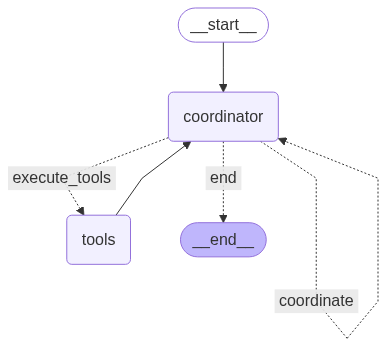

In [14]:
create_research_graph()

**Main Execution Functions :**

In [ ]:
def run_multiagent_system(company_name: str):
    """Runs the research system for a given company."""
    print(f"\n🕵️‍♀️ Detected company: {company_name}")
    print(f"🚀 Starting multi-agent research system...\n")
    
    app = create_research_graph()
    
    initial_state = {
        "messages": [HumanMessage(content=f"Generate a detailed research report on {company_name}")],
        "company_name": company_name,
        "ticker_symbol": None,
        "current_findings": {},
        "completed_tasks": [],
        "final_report": ""
    }
    
    try:
        final_state = None
        for state in app.stream(initial_state):
            final_state = state
            
        print("\n✅ Research completed successfully!")
        
        # Print final report if available
        if final_state and "final_report" in final_state.get("completed_tasks", []):
            print(f"\n{'='*80}")
            print("📊 FINAL REPORT")
            print(f"{'='*80}")
            print(final_state.get("final_report", "No report generated"))
            print(f"{'='*80}")
            
    except Exception as e:
        print(f"❌ Error during research execution: {str(e)}")
        logger.error(f"Multi-agent system error: {e}", exc_info=True)

def main_chat_loop():
    """Main chat loop to interact with the system."""
    print("💬 Multi-Agent Research System is live!")
    print("Ask for a 'deep dive' or 'report' on a company. Type 'exit' to quit.")
    
    while True:
        try:
            user_input = input("\n👤 You: ")
            
            if user_input.strip().lower() in ["exit", "quit"]:
                print("👋 Exiting. Goodbye!")
                break
            
            # Determine if user wants a company research report
            decision_prompt = f"""You are an assistant that determines if a user wants a company research report. 
            If they do, respond with the company name ONLY. Otherwise, respond with 'NONE'.
            
            User request: "{user_input}" """
            
            try:
                response = llm.invoke([SystemMessage(content=decision_prompt)]).content.strip()
                
                if response.upper() != "NONE":
                    run_multiagent_system(response)
                    print("\n💬 You can now continue chatting or request another company report.")
                else:
                    # General chat response
                    chat_response = llm.invoke([HumanMessage(content=user_input)]).content
                    print("🤖", chat_response)
                    
            except Exception as e:
                print(f"❌ Error processing request: {str(e)}")
                
        except KeyboardInterrupt:
            print("\n👋 Exiting. Goodbye!")
            break
        except Exception as e:
            print(f"❌ An unexpected error occurred: {str(e)}")
            logger.error("Error in main chat loop", exc_info=True)

if __name__ == "__main__":
    # Check if API keys are set
    if not all([
        os.environ.get("GROQ_API_KEY"),
        ALPHA_VANTAGE_API_KEY,
        TAVILY_API_KEY
    ]):
        print("⚠️ Warning: Please set your API keys before running the system!")
        print("Required API keys: GROQ_API_KEY, ALPHA_VANTAGE_API_KEY, TAVILY_API_KEY")
    
    main_chat_loop()

💬 Multi-Agent Research System is live!
Ask for a 'deep dive' or 'report' on a company. Type 'exit' to quit.


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


🤖 Hello! 👋  How can I help you today? 😊



INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"



🕵️‍♀️ Detected company: IBM
🚀 Starting multi-agent research system...

🏗️ Creating research workflow graph...
✅ Research graph created successfully!

🎯 Coordinator Agent - Processing...
📋 Next task: deep_search


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


🔧 Tool Execution Node - Processing tool calls...
🧠 Deep Search Tool - Researching: IBM
  -> Searching for: IBM company overview, structure, and business model
  -> Searching for: IBM company history, origin, and milestones
  -> Searching for: IBM key products, services, markets, and innovations
  -> Searching for: IBM tax practices, effective tax rate, tax avoidance controversies
  -> Searching for: IBM regulatory fines, ESG compliance, GDPR, or SEC issues
  -> Searching for: IBM controversies, lawsuits, legal settlements, ethical issues
  -> Searching for: SWOT analysis of IBM
  -> Searching for: IBM headquarters location, incorporation country, and legal name
  -> Searching for: IBM ownership structure, investors, founders, shareholders
  -> Searching for: is IBM a multinational? list countries of operation


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✅ Deep Search Result: ---

**Taxation and Compliance: IBM's compliance with regulations, and the company's compliance with regulations, and the company's compliance with regulations, and the company's compliance with regul...

🔧 TOOL RESULT (deep_search_and_summarize_tool):
---

**Taxation and Compliance: IBM's compliance with regulations, and the company's compliance with regulations, and the company's compliance with regulations, and the company's compliance with regulations, and the company's compliance with regulations, and the company's compliance with regulations, and the company's compliance with regulations, and the company's compliance with regulations, and the company's compliance with regulations, and the company's compliance with regulations, and the co...

✅ deep_search completed and findings saved.

🎯 Coordinator Agent - Processing...
📋 Next task: find_ticker


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


🔧 Tool Execution Node - Processing tool calls...
🔎 Ticker Finder Tool - Searching for ticker for: IBM


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✅ Ticker Found: IBM

🔧 TOOL RESULT (find_ticker_symbol_tool):
IBM...

✅ find_ticker completed. Ticker 'IBM' saved to state.

🎯 Coordinator Agent - Processing...
📋 Next task: financial_analysis


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


🔧 Tool Execution Node - Processing tool calls...
📊 Financial Data Tool - Analyzing financial data for: IBM
✅ Financial Data Result: FINANCIAL ANALYSIS for IBM:

--- STOCK PERFORMANCE ---
Latest Closing Price (2025-07-11): $283.5900
Volume: 3790679

--- KEY FINANCIAL METRICS ---
Market Cap: $267,136,385,000
P/E Ratio: 48.56
Dividend Yield: 0.0228

Description: International Business Machines Corporation (IBM) is an American multi...

🔧 TOOL RESULT (financial_data_tool):
FINANCIAL ANALYSIS for IBM:

--- STOCK PERFORMANCE ---
Latest Closing Price (2025-07-11): $283.5900
Volume: 3790679

--- KEY FINANCIAL METRICS ---
Market Cap: $267,136,385,000
P/E Ratio: 48.56
Dividend Yield: 0.0228

Description: International Business Machines Corporation (IBM) is an American multinational technology company headquartered in Armonk, New York, with operations in over 170 countries. The company began in 1911, founded in Endicott, New York, as the Computing-Tabulating-Recording Co...

✅ financial_analysis 

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


🔧 Tool Execution Node - Processing tool calls...
📰 News Sentiment Tool - Analyzing sentiment for: IBM


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✅ News Sentiment Result: NEWS & SENTIMENT ANALYSIS for IBM (2025-06-12 to 2025-07-12):

--- RECENT NEWS HIGHLIGHTS ---
1. Latest News - IBM Newsroom
   Source: https://newsroom.ibm.com/latest-news-corporate?l=100
2. IBM Power11 Raises the Bar for Enterprise IT - IBM Newsroom
   Source: https://newsroom.ibm.com/2025-07-08-ib...

🔧 TOOL RESULT (news_sentiment_tool):
NEWS & SENTIMENT ANALYSIS for IBM (2025-06-12 to 2025-07-12):

--- RECENT NEWS HIGHLIGHTS ---
1. Latest News - IBM Newsroom
   Source: https://newsroom.ibm.com/latest-news-corporate?l=100
2. IBM Power11 Raises the Bar for Enterprise IT - IBM Newsroom
   Source: https://newsroom.ibm.com/2025-07-08-ibm-power11-raises-the-bar-for-enterprise-it
3. Announcements - What's New - IBM
   Source: https://www.ibm.com/new/announcements
4. The Future of IBM Power, and the Latest With IBM Storage
   Source: h...

✅ sentiment_analysis completed and findings saved.

🎯 Coordinator Agent - Processing...
📋 Next task: industry_analysis


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


🔧 Tool Execution Node - Processing tool calls...
🏭 Industry Analysis Tool - Analyzing industry for: IBM
  -> Searching for: current market trends and future outlook for the industry of IBM
  -> Searching for: main competitors of IBM and their market positioning


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✅ Industry Analysis Result: ## Industry & Competitive Landscape

**Market Trends**

IBM operates in a dynamic and evolving technology landscape, with several key trends shaping its industry:

* **Digital Transformation:** Busine...

🔧 TOOL RESULT (industry_analysis_tool):
## Industry & Competitive Landscape

**Market Trends**

IBM operates in a dynamic and evolving technology landscape, with several key trends shaping its industry:

* **Digital Transformation:** Businesses across all sectors are increasingly adopting digital technologies to improve efficiency, enhance customer experiences, and drive innovation. IBM is well-positioned to capitalize on this trend through its cloud computing, data analytics, and artificial intelligence (AI) solutions.
* **Cloud Comp...

✅ industry_analysis completed and findings saved.

🎯 Coordinator Agent - Processing...
✅ All research tasks completed. Generating final report...
🔧 Tool Execution Node - Processing tool calls...
📋 Report Generation Tool - 

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


✅ Final Deep-Dive Report Generated Successfully!

🔧 TOOL RESULT (report_generation_tool):
# Comprehensive Research Report: IBM

## Executive Summary

IBM, a global technology giant with a rich history, is navigating a rapidly evolving technological landscape.  While its core strengths in enterprise IT, cloud computing, and data analytics remain solid, the company faces intense competition from agile tech players.  Recent news highlights IBM's focus on innovation, particularly with the launch of its Power11 processor, which aims to solidify its position in the hybrid cloud and AI mark...

🎉 Final report generated!
💾 Report saved to: IBM_report_20250712_230419.md

🎯 Coordinator Agent - Processing...
✅ All research tasks completed. Generating final report...

✅ Research completed successfully!

💬 You can now continue chatting or request another company report.
